In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import time
import io
import pandas as pd
from dataclasses import dataclass
from einops import rearrange

# ========================================
# 1) SHARED UTILITIES
# ========================================
@dataclass
class ModelArgs:
    DIM: int; FFN_DIM: int; NUM_HEADS: int; NUM_LAYERS: int
    NUM_KV_HEADS: int; VOCAB_SIZE: int; NORM_EPS: float
    ROPE_THETA: float; MAX_BATCH_SIZE: int; MAX_SEQ_LEN: int
    NUM_KV_HEAD_REP: int; HEAD_DIM: int; DROPOUT: float; DEVICE: str

class RMSNorm(nn.Module):
    def __init__(self, dim:int, eps:float=1e-6):
        super().__init__()
        self.eps = eps
        self.weight = nn.Parameter(torch.ones(dim))
    def forward(self, x):
        return self.weight * (x * torch.rsqrt(x.pow(2).mean(-1,keepdim=True)+self.eps)).type_as(x)

def precompute_freqs_cis(head_dim, seq_len, theta=10000.0, device="cuda"):
    freqs = 1.0/(theta**(torch.arange(0,head_dim,2).float()/head_dim).to(device))
    t = torch.arange(seq_len,device=device,dtype=torch.float32)
    return torch.polar(torch.ones((seq_len,head_dim//2),device=device), torch.outer(t,freqs))

def apply_rotary_emb(x, device="cuda"):
    B,L,H,D = x.shape
    xc = torch.view_as_complex(x.float().reshape(B,L,H,D//2,2))
    freqs = precompute_freqs_cis(D,L,device=device).view(1,L,1,D//2)
    xr = xc * freqs
    return torch.view_as_real(xr).reshape(B,L,H,D).type_as(x)

def repeat_kv(x,n_rep):
    B,L,nk,d = x.shape
    if n_rep==1: return x
    return x[:,:, :,None,:].expand(B,L,nk,n_rep,d).reshape(B,L,nk*n_rep,d)

# ========================================
# 2) TRANSFORMER
# ========================================
class FeedForward(nn.Module):
    def __init__(self,dim,ffn_dim,drop):
        super().__init__()
        self.w1=nn.Linear(dim,ffn_dim,bias=False)
        self.w2=nn.Linear(ffn_dim,dim,bias=False)
        self.w3=nn.Linear(dim,ffn_dim,bias=False)
        self.drop=nn.Dropout(drop)
    def forward(self,x):
        return self.w2(F.silu(self.w1(x))*self.drop(self.w3(x)))

class SelfAttention(nn.Module):
    def __init__(self,nh,nkh,nrep,dim,drop,bsz,seqlen,device):
        super().__init__()
        hd=dim//nh
        self.wq=nn.Linear(dim,nh*hd,bias=False)
        self.wk=nn.Linear(dim,nkh*hd,bias=False)
        self.wv=nn.Linear(dim,nkh*hd,bias=False)
        self.wo=nn.Linear(nh*hd,dim,bias=False)
        self.nh, self.nkh, self.nrep, self.hd = nh, nkh, nrep, hd
        self.drop, self.device = drop, device
        self.norm = RMSNorm(hd)
    def forward(self,x):
        B,L,_=x.shape
        q=self.wq(x).view(B,L,self.nh,self.hd)
        k=self.wk(x).view(B,L,self.nkh,self.hd)
        v=self.wv(x).view(B,L,self.nkh,self.hd)
        q=apply_rotary_emb(q,device=self.device)
        k=apply_rotary_emb(k,device=self.device)
        q=q.transpose(1,2)
        k=repeat_kv(k,self.nrep).transpose(1,2)
        v=repeat_kv(v,self.nrep).transpose(1,2)
        scores=(q@k.transpose(-2,-1))/math.sqrt(self.hd)
        mask=torch.triu(torch.full((L,L),float("-inf"),device=x.device),diagonal=1)
        attn=F.softmax(scores+mask,dim=-1)
        attn=F.dropout(attn,self.drop,training=self.training)
        out=attn@v
        out=self.norm(out).transpose(1,2).reshape(B,L,-1)
        return self.wo(out)

class TransformerBlock(nn.Module):
    def __init__(self,args:ModelArgs):
        super().__init__()
        self.attn=SelfAttention(args.NUM_HEADS,args.NUM_KV_HEADS,args.NUM_KV_HEAD_REP,
                                args.DIM,args.DROPOUT,args.MAX_BATCH_SIZE,args.MAX_SEQ_LEN,args.DEVICE)
        self.ffn=FeedForward(args.DIM,args.FFN_DIM,args.DROPOUT)
        self.norm1=RMSNorm(args.DIM); self.norm2=RMSNorm(args.DIM)
        self.drop=nn.Dropout(args.DROPOUT)
    def forward(self,x):
        x=x+self.drop(self.attn(self.norm1(x)))
        return x+self.drop(self.ffn(self.norm2(x)))

class LlamaTransformer(nn.Module):
    def __init__(self,args:ModelArgs):
        super().__init__()
        self.emb=nn.Embedding(args.VOCAB_SIZE,args.DIM,device=args.DEVICE)
        self.layers=nn.ModuleList([TransformerBlock(args) for _ in range(args.NUM_LAYERS)])
        self.norm=RMSNorm(args.DIM)
        self.head=nn.Linear(args.DIM,args.VOCAB_SIZE,bias=False,device=args.DEVICE)
    def forward(self,x):
        h=self.emb(x)
        for blk in self.layers: h=blk(h)
        return self.head(self.norm(h))

# ========================================
# 3) MAMBA
# ========================================
class SSM(nn.Module):
    def __init__(self,d_inner,state_size,device='cuda'):
        super().__init__()
        dt_rank=d_inner//16
        self.x_proj=nn.Linear(d_inner,dt_rank+2*state_size,bias=False,device=device)
        self.dt_proj=nn.Linear(dt_rank,d_inner,bias=True,device=device)
        A=torch.arange(1,state_size+1,device=device).repeat(d_inner,1)
        self.A_log=nn.Parameter(torch.log(A))
        nn.init.normal_(self.A_log,mean=-1,std=0.5)
        self.D=nn.Parameter(torch.ones(d_inner,device=device))
        self.log_eps=torch.log(torch.tensor(1e-7)).to(device); self.exp_clamp=20.0
    def forward(self,x):
        B,L,D=x.shape
        dtC,Bs,Cs=torch.split(self.x_proj(x),
                              [self.dt_proj.in_features,self.A_log.shape[1],self.A_log.shape[1]],dim=-1)
        dt=F.softplus(self.dt_proj(dtC))
        A=-torch.exp(self.A_log)
        logdA=torch.clamp(dt.unsqueeze(-1)*A.unsqueeze(0).unsqueeze(0),
                          min=self.log_eps,max=self.exp_clamp)
        dA=torch.exp(logdA)
        dB=dt.unsqueeze(-1)*Bs.unsqueeze(2)
        logR=torch.cumsum(torch.log(torch.clamp(dA,1e-7)),dim=1)
        R=torch.exp(torch.clamp(logR,max=self.exp_clamp))
        S=torch.cumsum(dB*x.unsqueeze(-1)*torch.exp(torch.clamp(-logR,max=self.exp_clamp)),dim=1)
        h=R*S
        return torch.einsum('bln,bldn->bld',Cs,h)+x*self.D.unsqueeze(0).unsqueeze(0)

class MambaBlock(nn.Module):
    def __init__(self,d_model,state_size=16,device='cuda'):
        super().__init__()
        d_inner=d_model*2
        self.norm=RMSNorm(d_model,eps=1e-5)
        self.inp=nn.Linear(d_model,2*d_inner,bias=False,device=device)
        self.conv=nn.Conv1d(d_inner,d_inner,kernel_size=4,padding=3,groups=d_inner,bias=True,device=device)
        self.ssm=SSM(d_inner,state_size,device=device)
        self.proj=nn.Linear(d_inner,d_model,bias=False,device=device)
        self.drop=nn.Dropout(0.1)
    def forward(self,x):
        r=x; y=self.norm(x)
        x_in,z=self.inp(y).chunk(2,dim=-1)
        xc=rearrange(x_in,'b l d->b d l')
        xc=self.conv(xc)[:,:,:x_in.size(1)]
        mixed=self.ssm(F.silu(rearrange(xc,'b d l->b l d')))
        out=self.proj(mixed*F.silu(z))
        return r+self.drop(out)

class Mamba(nn.Module):
    def __init__(self,d_model,n_layers,vocab_size,device='cuda'):
        super().__init__()
        self.emb=nn.Embedding(vocab_size,d_model,device=device)
        self.layers=nn.ModuleList([MambaBlock(d_model,device=device) for _ in range(n_layers)])
        self.norm=RMSNorm(d_model,eps=1e-5)
        self.head=nn.Linear(d_model,vocab_size,bias=False,device=device)
        self.head.weight=self.emb.weight
    def forward(self,x):
        h=self.emb(x)
        for blk in self.layers: h=blk(h)
        return self.head(self.norm(h))

# ========================================
# 4) GRU & minGRU
# ========================================
class GRUCell(nn.Module):
    def __init__(self,insz,hsz):
        super().__init__()
        self.ih=nn.Linear(insz,3*hsz); self.hh=nn.Linear(hsz,3*hsz); self.hsz=hsz
    def forward(self,xt,hp):
        ir,iz,in_t=self.ih(xt).chunk(3,1); hr,hz,hn=self.hh(hp).chunk(3,1)
        r=torch.sigmoid(ir+hr); z=torch.sigmoid(iz+hz); n=torch.tanh(in_t+r*hn)
        return (1-z)*n+z*hp

def parallel_scan_log(a,v):
    asum=F.pad(torch.cumsum(a,1),(0,0,1,0))
    lh0=torch.logcumsumexp(v-asum,1)
    return torch.exp(asum+lh0)[:,1:,:]

class ParallelLogMinGRU(nn.Module):
    def __init__(self,insz,hsz):
        super().__init__()
        self.z=nn.Linear(insz,hsz); self.h=nn.Linear(insz,hsz)
    def forward(self,x):
        Z=torch.sigmoid(self.z(x))
        B,L,_=x.size()
        h0=torch.zeros(B,1,self.h.out_features,device=x.device)
        lv=torch.log(torch.relu(self.h(x))+1e-6)
        return parallel_scan_log(torch.log1p(-Z),torch.cat([torch.log(torch.relu(h0)+1e-6),Z.log()+lv],1))

class StackedGRU(nn.Module):
    def __init__(self,ed,vs,nl):
        super().__init__()
        self.emb=nn.Embedding(vs,ed)
        self.layers=nn.ModuleList([GRUCell(ed,ed) for _ in range(nl)])
        self.head=nn.Linear(ed,vs)
    def forward(self,x):
        hseq=self.emb(x)
        for c in self.layers:
            B,L,D=hseq.size(); h=torch.zeros(B,D,device=x.device); out=[]
            for t in range(L):
                h=c(hseq[:,t],h); out.append(h.unsqueeze(1))
            hseq=torch.cat(out,1)
        return self.head(hseq)

class StackedMinGRU(nn.Module):
    def __init__(self,ed,vs,nl):
        super().__init__()
        self.emb=nn.Embedding(vs,ed)
        self.layers=nn.ModuleList([ParallelLogMinGRU(ed,ed) for _ in range(nl)])
        self.head=nn.Linear(ed,vs)
    def forward(self,x):
        hseq=self.emb(x)
        for m in self.layers: hseq=m(hseq)
        return self.head(hseq)

# ========================================
# 5) BENCHMARK
# ========================================
def count_params(m): return sum(p.numel() for p in m.parameters())
def model_size_kb(m):
    buf=io.BytesIO(); torch.save(m.state_dict(),buf)
    return round(len(buf.getvalue())/1024)
def measure_time_ms(m,inp,iters=20):
    m.eval()
    with torch.no_grad():
        for _ in range(5): m(inp)
        ts=[]
        for _ in range(iters):
            t0=time.time(); m(inp); ts.append((time.time()-t0)*1000)
    return sum(ts)/len(ts)

# settings
device='cuda'; vs,ed,nh,nl,ffn,bsz=1000,512,4,2,512,16
args=ModelArgs(ed,ffn,nh,nl,nh,vs,1e-5,10000,bsz,512,1,ed//nh,0.1,device)
models={
    "Transformer":LlamaTransformer(args).to(device),
    "Mamba":      Mamba(ed,nl,vs,device=device).to(device),
    "StackedGRU": StackedGRU(ed,vs,nl).to(device),
    "StackedMinGRU": StackedMinGRU(ed,vs,nl).to(device)
}

# 1) fixed length
inp512=torch.randint(vs,(bsz,512),dtype=torch.long,device=device)
records=[]
for name,m in models.items():
    records.append({
        "Model": name,
        "Params": count_params(m),
        "Size_KB": model_size_kb(m),
        "Time_512_ms": round(measure_time_ms(m,inp512), 2)
    })
df_fixed=pd.DataFrame(records).set_index("Model")

# 2) speed vs length
seq_lens=[128,256,512,768,1024]
speed_data={name:[round(measure_time_ms(m,torch.randint(vs,(bsz,L),dtype=torch.long,device=device)), 2) for L in seq_lens]
            for name,m in models.items()}
df_speed=pd.DataFrame(speed_data,index=seq_lens)
df_speed.index.name="Seq_Len"


/usr/local/lib/python3.10/dist-packages/torch/utils/_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(


In [2]:
print("=== Fixed Length (512) Comparison ===")
display(df_fixed)

=== Fixed Length (512) Comparison ===


,Params,Size_KB,Time_512_ms
Model,,,
Transformer,4696832,18355,7.38
Mamba,4034048,15765,30.06
StackedGRU,4176872,16319,188.45
StackedMinGRU,2075624,8111,0.72


In [3]:
print("\n=== Speed vs Sequence Length ===")
display(df_speed)


=== Speed vs Sequence Length ===


,Transformer,Mamba,StackedGRU,StackedMinGRU
Seq_Len,,,,
128,2.74,7.81,47.84,0.67
256,3.89,15.25,94.05,2.72
512,7.39,30.05,196.54,4.56
768,12.26,45.01,282.27,8.78
1024,17.08,59.72,369.51,13.03


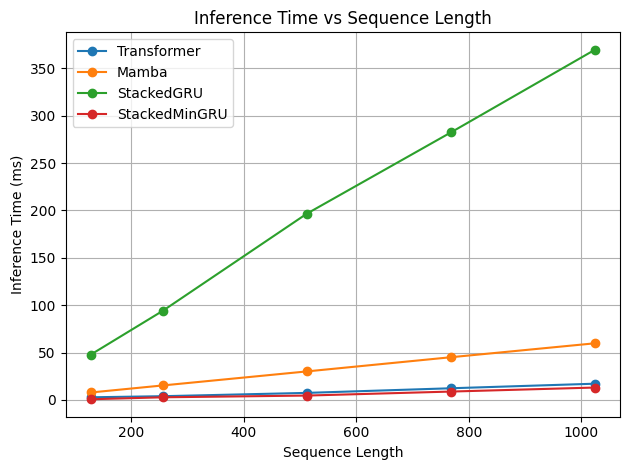

In [4]:
import matplotlib.pyplot as plt

# df_speed: DataFrame with index=sequence lengths and columns=model names, values=time in ms
plt.figure()
for model in df_speed.columns:
    plt.plot(df_speed.index, df_speed[model], marker='o', label=model)
plt.xlabel("Sequence Length")
plt.ylabel("Inference Time (ms)")
plt.title("Inference Time vs Sequence Length")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
